In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
!pip install wordcloud
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [54]:
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

In [85]:
df = pd.read_csv("Flipkart_data.csv")

In [86]:
df.shape

(20000, 15)

In [87]:
#Reducing the product category to base form
'''
The product category tree is a comprehensive categorisation of each of the data points. The primary category for each
point is identified, and these are the values that will be predicted by the model.
A new column named "Category" is made and contains the primary category corresponding to each data point. 
'''
category = df['product_category_tree']
main_category = []

for i in category :
    words = i.split()
    if ">>" in words : 
        index = words.index('>>')
        nameOfCategory = words[0 : index]
        nameOfCategory = " ".join(nameOfCategory)
    else :
        nameOfCategory = "none"
    
    nameOfCategory = nameOfCategory.replace('["', '')
    main_category.append(nameOfCategory)

df = df.assign(Category = main_category)

In [80]:
categories = df['Category'].value_counts()
categories

Clothing                             6220
Jewellery                            3531
Footwear                             1227
Mobiles & Accessories                1099
Automotive                           1012
Home Decor & Festive Needs            929
Beauty and Personal Care              710
Home Furnishing                       700
Kitchen & Dining                      647
Computers                             578
Watches                               530
Baby Care                             483
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     313
none                                  290
Bags, Wallets & Belts                 276
Furniture                             180
Sports & Fitness                      170
Cameras & Accessories                  82
Home Improvement                       81
Health & Personal Care Appliances      43
Gaming                                 36
Sunglasses                        

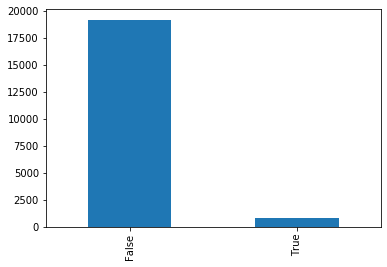

In [58]:
#Plotting distinct values of an attribute against their count
''' There are only two possible values for "is_FK_Advantage_product" - True and False
19215 data points have a False value for this attribute and 785 products have a True value. Since a large majority of the
data points have the same value, hence it will be difficult to distinguish the categories using this property. 
So this property will not contribute towards determining the product category.
''' 

df['is_FK_Advantage_product'].value_counts().plot(kind = 'bar')

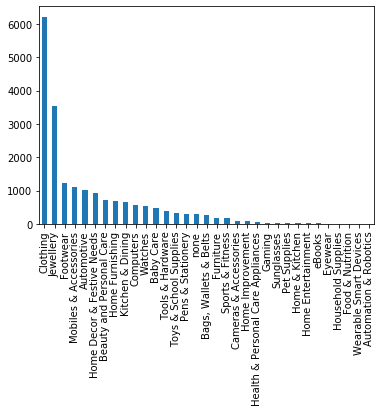

In [161]:
df['Category'].value_counts().plot(kind = 'bar')

In [59]:
#counting unique values in rating
''' For both attributes - overall and product rating there are 18151 records which have no rating, and the rest of the
data points have rating ranging from 5 to 1. Since a majority of data points do not have rating, hence these two attributes
do not contribute to determining the category of a given product. 
'''

df['product_rating'].value_counts()

df['overall_rating'].value_counts()

No rating available    18151
5                        620
4                        246
1                        171
3                        168
2                         80
4.5                       67
3.7                       51
4.2                       47
3.5                       45
4.3                       45
3.6                       25
4.7                       24
4.1                       24
2.5                       23
3.8                       23
4.8                       21
3.2                       20
3.3                       17
4.4                       16
3.9                       15
3.4                       13
2.3                       12
2.8                       11
2.7                       10
4.6                        9
2.2                        8
3.1                        7
2.4                        5
2.9                        5
1.7                        4
4.9                        4
1.5                        4
1.3                        4
2.6           

In [60]:
#Retail price
'''
Taking a random value from retail price column(eg - value of maximum frequency retail price 999.0 in this case), 
and for all the data points their categories are stored in a varibale category_max_freq
Using a Counter, we see that the same retail price value can belong to a whole variety of categories.
Hence, retail price is not a good determinant for category.
'''
max_freq_retail = df['retail_price'].value_counts().keys()[0]
category_max_freq = df['Category'].loc[df['retail_price'] == max_freq_retail]
Counter(category_max_freq)

Counter({'Clothing': 543,
         'Footwear': 104,
         'Bags, Wallets & Belts': 20,
         'Baby Care': 67,
         'Watches': 66,
         'Toys & School Supplies': 6,
         'none': 33,
         'Pens & Stationery': 26,
         'Mobiles & Accessories': 75,
         'Computers': 53,
         'Jewellery': 133,
         'Home Decor & Festive Needs': 36,
         'Automotive': 10,
         'Beauty and Personal Care': 6,
         'Home Improvement': 1,
         'Gaming': 4,
         'Health & Personal Care Appliances': 4,
         'Cameras & Accessories': 4,
         'Kitchen & Dining': 8,
         'Sunglasses': 7,
         'Sports & Fitness': 4,
         'Tools & Hardware': 13,
         'Home Furnishing': 59,
         'Wearable Smart Devices': 1,
         'Home Entertainment': 2,
         'Pet Supplies': 1})

In [88]:
#Removing columns which do not contribute to determining the category of a product
'''
The columns below do not contribute signficantly in determining the category of a product, as the values are either to 
discrete and random or a large majority of the data points have the same value for these attributes. Hence they are 
removed from the data frame.

The main column used to identify the category of a data point is description. Additional columns such as
-> product name
-> brand
-> pid
-> product specification
will be analyzed, and if by addition of these columns the accuracy of our model increases, then these attributes will also
be considered to determine the category of a data point.

'''
df = df.drop(["product_rating", "overall_rating", "crawl_timestamp", "product_url", "uniq_id", "retail_price", "discounted_price", "is_FK_Advantage_product", "image"], axis = 1)

In [162]:
df.columns

Index(['product_name', 'product_category_tree', 'pid', 'description', 'brand',
       'product_specifications', 'Category'],
      dtype='object')

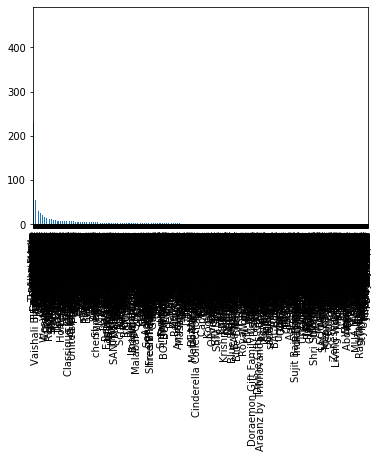

In [163]:
df['brand'].value_counts().plot(kind = 'bar')

In [89]:
#dropping rows with missing description
df = df.dropna(axis = 0, subset = ['description'])
df.count()

product_name              19998
product_category_tree     19998
pid                       19998
description               19998
brand                     14135
product_specifications    19984
Category                  19998
dtype: int64

In [ ]:
''' Text Processing :
1. Removing punctuation
2. Converting each sample into tokens
3. Removing the stop words
4. Preprocessing Data: Using a Lemmatizer
5. Saving the cleaned data
'''

In [65]:
#1. Removing punctuation

import string

def remove_punct(text : str) -> str :
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

df['cleaned_description'] = df['description'].apply(lambda x : remove_punct(x))

df.head()

,product_name,product_category_tree,pid,description,brand,product_specifications,Category
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,Key Features of Alisha Solid Womens Cycling Sh...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,FabHomeDecor Fabric Double Sofa Bed Finish Col...,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",Furniture
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,Key Features of AW Bellies Sandals Wedges Heel...,AW,"{""product_specification""=>[{""key""=>""Ideal For""...",Footwear
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,Key Features of Alisha Solid Womens Cycling Sh...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,Specifications of Sicons All Purpose Arnica Do...,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",Pet Supplies


In [68]:
#2. Tokenization

import re

def tokenize(text : str) -> [str]:
    tokens = re.split('\W+', text)
    return tokens

df['cleaned_description'] = df['description'].apply(lambda x : tokenize(x.lower())) 

df.head()

,product_name,product_category_tree,pid,description,brand,product_specifications,Category
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,"[key, features, of, alisha, solid, womens, cyc...",Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,"[fabhomedecor, fabric, double, sofa, bed, fini...",FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",Furniture
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,"[key, features, of, aw, bellies, sandals, wedg...",AW,"{""product_specification""=>[{""key""=>""Ideal For""...",Footwear
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,"[key, features, of, alisha, solid, womens, cyc...",Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,"[specifications, of, sicons, all, purpose, arn...",Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",Pet Supplies


In [70]:
#3. Removing Stopwords

# All English Stopwords
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]# To remove all stopwords
    return text

df['cleaned_description'] = df['description'].apply(lambda x : remove_stopwords(x))

df.head()

,product_name,product_category_tree,pid,description,brand,product_specifications,Category
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,"[key, features, alisha, solid, womens, cycling...",Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,"[fabhomedecor, fabric, double, sofa, bed, fini...",FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",Furniture
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,"[key, features, aw, bellies, sandals, wedges, ...",AW,"{""product_specification""=>[{""key""=>""Ideal For""...",Footwear
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,"[key, features, alisha, solid, womens, cycling...",Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,"[specifications, sicons, purpose, arnica, dog,...",Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",Pet Supplies


In [71]:
#4. Preprocessing Data: Using a Lemmatizer

wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

df['cleaned_description'] = df['description'].apply(lambda x : lemmatizing(x))

df.head()

,product_name,product_category_tree,pid,description,brand,product_specifications,Category
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,"[key, feature, alisha, solid, woman, cycling, ...",Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,"[fabhomedecor, fabric, double, sofa, bed, fini...",FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",Furniture
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,"[key, feature, aw, belly, sandal, wedge, heel,...",AW,"{""product_specification""=>[{""key""=>""Ideal For""...",Footwear
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,"[key, feature, alisha, solid, woman, cycling, ...",Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,"[specification, sicons, purpose, arnica, dog, ...",Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",Pet Supplies


In [ ]:
#5. Saving the cleaned data

data.to_csv("Flipkart_E-commerce_cleaned.csv", sep = ',')

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

In [90]:
#TF-IDF - Applying the Vectorizer

def clean_text(text : str) -> str :
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    return text

tfidf_vect = TfidfVectorizer(analyzer = clean_text)
X_tfidf = tfidf_vect.fit_transform(df['description'])

print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(19998, 103)


In [118]:
#Splitting the data into testing and training sets
'''
Using the train_test_split function present in sklearn library, the given dataset is split into training and testing data.
70% of the dataset is kept for training and the rest of the 30% data is used as the test set
'''

training_data, testing_data = train_test_split(df, test_size = 0.30, random_state = 2000)

X_train = tfidf_vect.transform(training_data['description'].values)
X_test = tfidf_vect.transform(testing_data['description'].values)

Y_train = training_data['Category'].values
Y_test = testing_data['Category'].values

In [119]:
#K-Nearest Neighbour

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors = 4)

knn_model = neigh.fit(X_train, Y_train)

y_pred = knn_model.predict(X_test)

accuracy = metrics.accuracy_score(Y_test, y_pred)
print("Accuracy", accuracy)

Accuracy 0.8405


In [117]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

scikit_log_reg = LogisticRegression(solver = 'sag', random_state = 0, C = 5, max_iter = 1000, multi_class = 'ovr')

logistic_model = scikit_log_reg.fit(X_train, Y_train)

y_pred = logistic_model.predict(X_test)

accuracy = metrics.accuracy_score(Y_test, y_pred)
print("Accuracy", accuracy)

C:\Users\Malaika Agrawal\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Accuracy 0.6571666666666667


In [131]:
#SVM

from sklearn import svm

clf = svm.SVC()
svm_model = clf.fit(X_train, Y_train)

y_pred = svm_model.predict(X_test)

accuracy = metrics.accuracy_score(Y_test, y_pred)
print("Accuracy", accuracy)

C:\Users\Malaika Agrawal\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy 0.4175


In [113]:
#Decision Trees

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state = 0, max_depth = 3)

decision_tree_model = decision_tree.fit(X_train, Y_train)

y_pred = decision_tree_model.predict(X_test)

accuracy = metrics.accuracy_score(Y_test, y_pred)
print("Accuracy", accuracy)


Accuracy 0.41333333333333333


In [128]:
#Result Visualization

def plot_result(model, X_test_Y_test) : 
    plot_confusion_matrix(model, X_test, Y_test)  
    plt.show()

In [134]:
df.columns

Index(['product_name', 'product_category_tree', 'pid', 'description', 'brand',
       'product_specifications', 'Category'],
      dtype='object')

In [151]:
#Finding out whether brand attribute can be used to determine the category of a product

df['brand'].value_counts()

Allure Auto        469
Regular            313
Voylla             299
Slim               288
TheLostPuppy       229
                  ... 
Besto                1
Tradeyard impex      1
Pure Source          1
Sixthsense           1
Zari Boxes           1
Name: brand, Length: 3499, dtype: int64

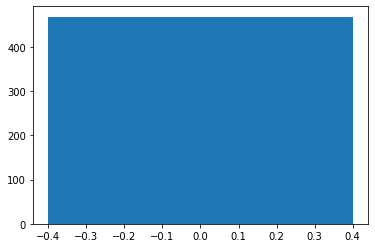

In [158]:
#Finding the category of all data points corresponding to a particular brand

categories_by_brand = df['Category'][df['brand'] == 'Allure Auto']
labels, values = zip(*Counter(categories_by_brand).items())

indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.show()

'''
We can see that all the data points of a particular brand point to the same category.
Hence, brand can be used to determine the category.
But there are a large number of null values for the brand attribute, so it cannot be taken as the primary attribute.
'''